In [255]:
from numpy import *
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from matplotlib import animation
import scipy.sparse as sp
import warnings

%matplotlib inline
plt.rcParams['animation.html'] = 'html5'
warnings.filterwarnings('ignore')

####################CONST####################
hbar = 1.05E-34      # Plancks konstant
m = 9.11E-31         # elektronmasse
V0 = 1.6E-19         # 1 eV
k=V0/2               # fjærkonstant
omega = sqrt(k / m)  # vinkelfrekvens
Ntot = 1000          # Intervallbredde
N = 100              # Parabolbredde
dx = 1.0E-10         # 1Å
harmonic = True
##############################################

#################VARIABLE#####################
E0 = V0
sigma = N / 4 * dx
k0 = sqrt(2.0*m*E0)/hbar
p0 = hbar*k0
##############################################

def V(x):
    if not harmonic:         # Fri partikkel
        return zeros_like(x)
    else:                    # Harmonisk
        V = V0 * ((x - x0) / (N * dx)) ** 2  # N=x/dx
        mask = ((x0 - N * dx) < x) & (x < (x0 + N * dx))
        return where(mask, V, V0)
    
def animator(time=200,figsize=(14,4)):
    def init():
        line.set_data([], [])
        marker1.set_data([], [])
        marker2.set_data([], [])
        marker3.set_data([], [])
        return line,marker1, marker2, marker3,

    def animate(i):
        t = tArr[i]
        line.set_data(x, BigPsiSquared(t))
        #line.set_data(x, BigPsi(t)*10**4) 
        marker1.set_data(meanX(t) + sigmaX(t), 0)
        marker2.set_data(meanX(t) - sigmaX(t), 0)
        marker3.set_data(meanX(t), 0)
        return line,marker1, marker2, marker3,

    tArr = arange(time) * 2E-15
    fig = plt.figure(figsize=figsize)
    ymax = 1.7E8 
    
    if harmonic and E0<V0:
        ax=plt.axes(xlim=(3E-8,7E-8),ylim=(0, ymax))
    elif harmonic and E0>V0:
        ax=plt.axes(xlim=(0E-8,10E-8),ylim=(0, ymax))
    else:
        ax=plt.axes(xlim=(0,Ntot*dx),ylim=(0, ymax))
    
        
    line, = ax.plot([], [], lw=1,label=r'$\left| \Psi \right|^2 $')
    marker1, = ax.plot([], [], 'bo',label=r'$\Delta x_t$')
    marker2, = ax.plot([], [], 'bo')
    marker3, = ax.plot([], [], 'co',label=r'$\langle x \rangle_t$')
    plt.xlabel('$x$ (m)')

    if harmonic:
        if E0<V0:
            b0 = x[abs(V(x) * 10 ** 27 - ones_like(x) * E0 * 10 ** 27) < 0.01E8]
            plt.plot(b0, zeros_like(b0), 'ro',label='$b_0$')

        plt.plot(x, ones_like(x) * E0 * 10 ** 27,label='$E_0=p_0^2/2m$')
        plt.plot(x, V(x) * 10 ** 27,label='$V$')
        plt.plot(x0, 0, 'ko', label='$x_0$')
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.legend(loc='upper left', borderaxespad=1.5,borderpad=0.1)
    anim=animation.FuncAnimation(fig, animate, init_func=init, repeat=True, frames=len(tArr), interval=64, blit=True)
    plt.close(fig)
    display(HTML(anim.to_html5_video()))
    
def getBigPsi(E0=E0, sigma=sigma, harmonic=harmonic):
    k0 = sqrt(2.0*m*E0)/hbar
    p0 = hbar*k0
    globals().update(p0=p0, sigma=sigma, harmonic=harmonic, k0=k0, E0=E0)

    subsupDiag = -ones(Ntot - 1) * hbar ** 2 / (2 * m * dx ** 2)
    diagon = ones(Ntot) * hbar ** 2 / (m * dx ** 2) + V(x.T)
    H = array([diagon, subsupDiag, subsupDiag]); offsets = array([0, -1, 1])
    H = sp.diags(H, offsets, shape=(Ntot, Ntot))
    E, Psi = linalg.eigh(H.todense())  
    E, Psi = asarray(E).reshape(Ntot, 1), asarray(Psi, dtype=complex128)
    quadPsi = linalg.norm(Psi, 2, 0) ** 2 * dx
    normFactor = quadPsi[0]  
    Psi /= sqrt(normFactor)  
    PsiConj = conj(Psi)
    
    coefficient = (2 * pi * sigma ** 2) ** (-0.25)
    envelope = exp(-(x - x0) ** 2 / (4 * sigma ** 2))
    planewave = exp(1j * k0 * x)
    Psi0=coefficient * envelope * planewave 
    
    c = (PsiConj.T @ Psi0 * dx)
    BigPsi = lambda t: Psi @ (c * (exp(-1j * E * t / hbar)))    
    return BigPsi

meanX=lambda t: (x.T)@BigPsiSquared(t)*dx
meanX2=lambda t: (x.T)**2@BigPsiSquared(t)*dx
sigmaX=lambda t: sqrt(meanX2(t)-meanX(t)**2)
analyticSigmaX=lambda t: sqrt(sigma**2+hbar**2*t**2/(4*m**2*sigma**2))

BigPsiSquared = lambda t: abs(BigPsi(t)) ** 2 
gradBigPsi=lambda t: gradient(BigPsi(t),dx, axis=0)
meanP=lambda t: -diag(1j*hbar*conj(BigPsi(t).T)@gradBigPsi(t)*dx)
meanP2=lambda t: diag(hbar**2*conj(gradBigPsi(t).T)@gradBigPsi(t)*dx)
sigmaP=lambda t: sqrt(meanP2(t)-meanP(t)**2)

heisenProd=lambda t: sigmaP(t)*sigmaX(t)        


# Innledning
Et grunnleggende postulat i kvantemekanikken sier at tilstanden til et system er fullstendig beskrevet av systemets bølgefunksjon $\Psi$, hvis løsning kommer av Schrödingerlikningen 
\begin{equation}\label{eq:SL}
    i\hbar\frac{\partial\Psi}{\partial t}=\hat{H}\Psi
\end{equation}
hvor $\hat{H}=-\frac{\hbar^2}{2m}\nabla^2+V$ er systemets Hamiltonoperator. 

Ved Bornes sannsynlighetstolkning vil en kvantemekanisk partikkel kunne beskrives i henhold til en sannsynlighetsfordeling gitt ved $\left|\Psi\right|^2$. Vi skal utelukkende studere éndimensjonale potensialer.
For tidsuavhengige potensialer $V=V(x)$ vil likning \eqref{eq:SL} kunne løses ved seperasjon av variable, slik at bølgefunksjonen blir på formen 
\begin{equation}\label{eq:Psi}
    \Psi(x,t)=\psi(x)e^{-iEt/\hbar}
\end{equation}
der $\psi$ er løsningen av den tidsuavhengige Schrödingerlikningen
\begin{equation}
    \label{eq:TUSL}
    \hat{H}\psi=E\psi
\end{equation}
Dette er en egenverdilikning som kvantiserer systemets tilstander i et egenfunksjonsett $\{ \psi_k \}$  med tilhørende spekter $\{ E_k \}$. Hvis $\psi_k \in \mathcal{H}$ vil $\{ \psi_k \}$ danne en ortogonal basis for Hilbertrommet, slik at 
\begin{equation}\label{eq:psiDotpsi}
    \langle \psi_i,\psi_k \rangle=\int_{-\infty}^{\infty}{\psi_i^* \psi_k} \space dx=\delta_{ik}
\end{equation}
for normerte $\psi_k$. Bølgefunksjonen \eqref{eq:Psi} beskriver en stasjonær tilstand der sannsynlighetsfordelingen ikke avhenger av tiden. Av basisegenskapene til $\{ \psi_k \}$ vil imidlertid en generell bølgefunksjon $\Psi \in \mathcal{H}$ kunne utvikles som 
\begin{equation}\label{eq:expansion}
    \Psi=\sum_{k} c_k \psi_k e^{-iE_kt/\hbar}
\end{equation}
som nødvendigvis må gi opphav til en tidsavhengig sannsynlighetsfordeling.   
Utviklingskoeffisientene finnes ved å projisere begynnelsestilstanden på egenfunksjonene

\begin{equation}\label{eq:expansionCoeff}
    c_k=\langle \psi_k,\Psi(x,0) \rangle=\int_{-\infty}^{\infty}{\psi_k^* \Psi(x,0)} \space dx
\end{equation}
  
og resulterer i 
\begin{equation}\label{eq:expansionCoeff2}
    \langle \Psi,\Psi \rangle=\sum_k \left| c_k \right|^2=1 \;\;\; \forall t 
\end{equation}
 når $\{ \psi_k \}$ er ortonormale. Av likning \eqref{eq:expansionCoeff2} er det klart at utviklingskoeffisientene selv utgjør en (diskret) sannsynlighetsfordeling, som vekter bidraget av hver $\psi_k$ i $\Psi$.

I følge de Broglie vil en partikkel med veldefinert impuls ha en tilstand som svarer til 

\begin{equation}\label{eq:matterWave}
    \Psi=\psi_k e^{-iEt/\hbar} \propto e^{i(kx-\omega t)}=e^{i(px-Et)/\hbar}
\end{equation}

med postulert impuls $p=\frac{h}{\lambda}=\hbar k$, energi $E=\frac{p^2}{2m}$ og dispersjonsrelasjon
\begin{equation}\label{eq:dispersion}
\omega=\frac{E}{\hbar}=\frac{\hbar k^2}{2m}
\end{equation}

Dette er en kompleks bølgefunksjon der både real-og imaginærdel er harmoniske planbølger med veldefinert bølgelengde $\lambda=\frac{2 \pi}{k}$. Gitt at bølgefunksjonen beskriver en fri partikkel vil den være egenfunksjon til både $\hat{p}=-i \hbar \frac{\partial}{\partial x}$ og $\hat{H}=\frac{\hat{p}^2}{2m}$ med egenverdier $p$ og $E$ avhengig av $k$.  I det frie rom er det ingen betingelser på $k$ og $\lambda$ slik at vi har et uendelig antall egenfunksjoner $\{ \psi_k \}$ og kontinuerlige spektere $\{ p \}$ og $\{ E \}$.
Generelt vil en observabel kun være skarpt definert hvis systemet er i en egentilstand til observabelens operator, og ettersom $\left[ \hat{p},\hat{H} \right]=0$ er det ikke være noe i veien for at partikkelen har veldefinert $p$ og $E$ samtidig. At $\Psi$ oppfyller \eqref{eq:TUSL} innebære at bølgefunksjonen beskriver stasjonære tilstander der $\langle p\rangle$ og $\langle E \rangle$ er konstant i tiden. 

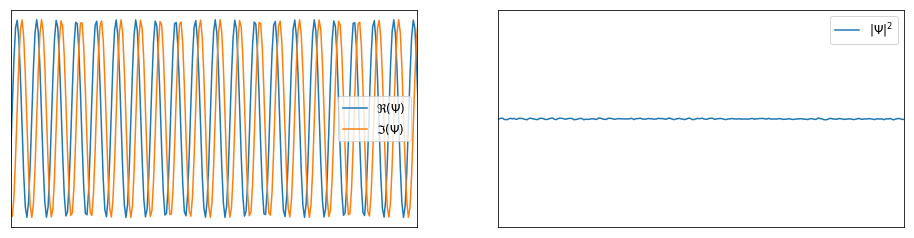

In [256]:
BigPsi = getBigPsi(E0=V0,sigma=1,harmonic=False)

fig, axArr =plt.subplots(1, 2, sharex=True,figsize=(16,4),)
axArr[0].set_xlim(0.375E-7,0.625E-7)
axArr[0].axes.get_yaxis().set_visible(False)
axArr[0].axes.get_xaxis().set_visible(False)
axArr[0].ticklabel_format(style='sci',axis='y',scilimits=(0,0))
axArr[0].plot(x,BigPsi(0),label=r'$ \Re \left( {\Psi} \right)$')
axArr[0].plot(x,imag(BigPsi(0)),label=r'$\Im \left( {\Psi} \right) $')
axArr[0].legend(loc='best',fontsize='large')
axArr[1].set_xlim(0.375E-7,0.625E-7)
axArr[1].axes.get_yaxis().set_visible(False)
axArr[1].axes.get_xaxis().set_visible(False)
axArr[1].ticklabel_format(style='sci',axis='y',scilimits=(0,0))
axArr[1].plot(x,BigPsiSquared(0),label=r'$\left| \Psi \right|^2 $')
axArr[1].legend(loc='best',fontsize='large')

plt.show()

På figuren har vi de harmoniske planbølgene. Både realdel og imaginærdel er sinusoider. Hvis vi betrakter det resulterende absoluttkvadratet som en gaussisk bølgepakke er det klart at denne må ha et uendelig standardavvik. Når vi danner en bølgepakke superponerer vi de-broglie bølgene slik at realdel og imaginærdel danner hvert sitt bølgetog. For å gjøre dette må sinusoidene adderes slik at de gir konstruktiv interferens i området vi ønsker bølgetoget og destruktiv interferens til null amplitude ellers. Brede bølgepakker innebærer at et mindre område av rommet skal ha null amplitude, slik at det trengs færre planbølger siden vi skal destruere et mindre område. Vi må altså superponere flere planbølger jo mer lokalisert vi ønsker bølgepakkene. Den resulterende bølgefunksjonen er en lineærkombinasjon av impulsegenfunksjoner svarende til forskjellige egenverdier, og det er klart at jo flere egenfunksjoner som inngår i summen, jo flere verdier av impulsen vil en måling kunne gi.
Ettersom bølgefunksjonen på figuren ikke går til null ved uendeligheten kan ikke $\Psi \in \mathcal{H}$, og $\left| \Psi \right|^2$ kan følgelig ikke være normerbar i henhold til likning \eqref{eq:psiDotpsi}. Dette innebærer at stasjonære partikler i realiteten ikke er fysisk realiserbare tilstander.
Da $\langle \psi_k,\psi_k' \rangle \propto \delta(k-k')$ er likevel egenfunksjonene Dirac-ortonormale, hvilket innebærer at  $\{ \psi_k\}$ fortsatt utgjør en fullstendig basis for $\mathcal{H}$, selv om funksjonene selv ikke er medlem av vektorrommet. Generelt antar man i kvantemekanikken at alle egenfunksjonssett svarende til Hermitske operatorer er fullstendige. I tilfellet der $k$ kan ta alle mulige reelle verdier vil en vilkårlig $\Psi \in \mathcal{H}$ analogt med likning \eqref{eq:expansion} kunne utvikles ved

\begin{equation}\label{eq:contExpansion}
    \Psi \propto \int_{-\infty}^{\infty} c(k)\psi_k e^{-iEt/\hbar} \space dk
\end{equation}

Her er utviklingskoeffisientene fortsatt gitt ved projeksjonen \eqref{eq:expansionCoeff}, og $\{ \psi_k\}$ er et felles egenfunksjonssett både for Hamilton- og impulsoperatoren. Utviklingskoeffisientene er i realiteten fouriertransformasjonen av begynnelsestilstanden, og beskriver med dette frekvensinnholdet i signalet, manifistert f.eks. gjennom bølgetallet (angulær frekvens i rommet), eller ved de Broglie gjennom impulsen og energien. Når vi kjenner impulsen/energien i signalet er tilstandens dynamikk spesifisert, og vi kan finne tilstandens respons i rom (og tid) gjennom likning \eqref{eq:contExpansion}. Uskarphetsrelasjonen i Fourieranalysen innebærer at en delokalisert bølgefunksjon vil ha en svært lokalisert fouriertransformasjon, og omvendt. Som totale ytterligheter så vi at den harmoniske planbølgen, som var ''uendelig" utspredt i posisjon, hadde en fouriertranformasjon som svarte til en $\delta(k-k')$-funksjon konsentrert rundt én spesifikk frekvensverdi. Mer generelt; hvis vi har en gausisk bølgepakke ved $t=0$ sentrert rundt origo 
$\Psi(x,0)=e^{-x^2 \mathbin{/}2a}$, der $a=2\left(\Delta x \right)^2$, så vil fouriertransformasjonen tilsvare en gausisk bølgepakke i frekvensen med invers bredde $1/a=2\left(\Delta k \right)^2=2\left(\frac{\Delta p}{\hbar} \right)^2$ med resultatet  $\Delta p \Delta x = \hbar /2$. Dette resultatet gjelder når tilstanden er gaussisk både i posisjonsrepresentasjonen og frekvensrepresentasjonen. I det generelle tilfellet gjelder Heisenbergs uskarphetsrelasjon 
\begin{equation}\label{eq:Heisenberg}
   \Delta p \Delta x \geq \hbar /2
\end{equation}
som altså er et nødvendig resultat som følge av partiklenes bølgenatur.

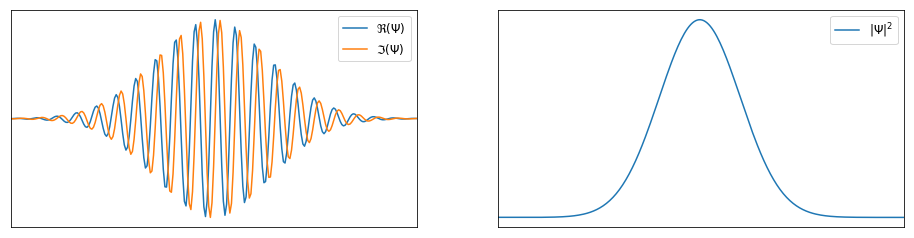

In [257]:
BigPsi = getBigPsi(E0=V0,sigma=N/4*dx,harmonic=False)

fig, axArr =plt.subplots(1, 2, sharex=True,figsize=(16,4),)
axArr[0].set_xlim(0.375E-7,0.625E-7)
axArr[0].ticklabel_format(style='sci',axis='y',scilimits=(0,0))
axArr[0].axes.get_yaxis().set_visible(False)
axArr[0].axes.get_xaxis().set_visible(False)
axArr[0].plot(x,BigPsi(0),label=r'$ \Re \left( {\Psi} \right)$')
axArr[0].plot(x,imag(BigPsi(0)),label=r'$\Im \left( {\Psi} \right) $')
axArr[0].legend(loc='best',fontsize='large')
axArr[1].set_xlim(0.375E-7,0.625E-7)
axArr[1].axes.get_yaxis().set_visible(False)
axArr[1].axes.get_xaxis().set_visible(False)
axArr[1].ticklabel_format(style='sci',axis='y',scilimits=(0,0))
axArr[1].plot(x,BigPsiSquared(0),label=r'$\left| \Psi \right|^2 $')
axArr[1].legend(loc='best',fontsize='large')

plt.show()

Når vi så at den harmoniske planbølgen i prinsippet er en fysisk urealiserbar tilstand er det naturlig å i denne øvingen heller betrakte en bølgepakke hvis starttilstand

\begin{equation}\label{eq:Gaussian} 
    \Psi(x,0)=(2\pi\sigma^2)^{-1/4}e^{-(x-x_0)^2/4\sigma^2}e^{ip_0x/\hbar}
\end{equation}

har en frekvensfordeling som er gausisk fordelt rundt en sentral verdi $k_0$, med en bredde større enn $\delta(k-k_0)$-funksjonen. Denne verdien for bølgetallet er igjen gitt av en startenergi $E_0$ gjennom likning \eqref{eq:dispersion}, og det er denne verdien vi skal bruke i øvingen til å kontrollere de andre variablene. I motsetning til planbølgen er $\Psi \in \mathcal{H}$, og $\left | \Psi \right|^2$ beskriver sannsynlighetsfordelingen til en partikkel vi har klart å lokalisere rundt $x=x_0$ ved å fordele frekvensinnholdet rundt en sentral impulsverdi $p_0=\sqrt{2mE_0}$.   
Vi skal visualisere $\left | \Psi \right|^2$ i henholdsvis et harmonisk- og konstant potensiale 

\begin{equation}\label{eq:potential} 
  V(x) =
  \begin{cases}
  0 & \text{Fri partikkel} \\
  V_0(x-x_0)^2 & \text{Harmonisk partikkel} \\
  \end{cases}
\end{equation}


ved å numerisk bestemme egenfunksjonene som oppfyller likning \eqref{eq:TUSL}, og siden utvikle $\Psi$ i henhold til \eqref{eq:expansion}. Med denne representasjonen kan forventningsverdien av en observerbar størrelse $F$ beregnes som 
\begin{equation}\label{eq:expectation}
    \langle F \rangle=\int_{-\infty}^{\infty}\Psi^{*}\hat{F} \space \Psi \space dx
\end{equation}
for enhvert tid. 

%At det svarer to verdier av $p$, og dermed to utgaver av $\Psi_k$, til hver verdi av $E$ innebærer en degenerasjonsgrad 2 %av energispekteret.  
%Selv om de Broglie-bølgen har 
%{m}$  er imidlertid ikke 

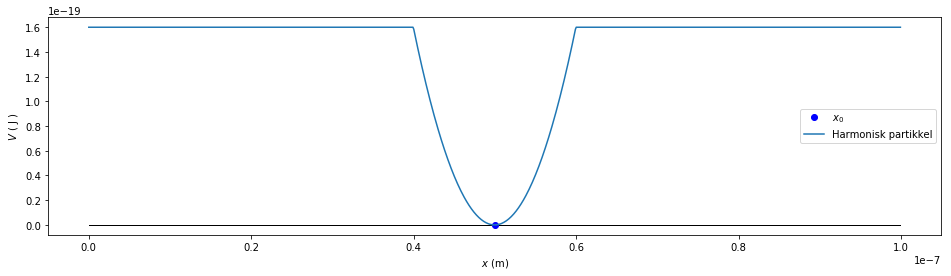

In [262]:
x = arange(Ntot) * dx
x0 = x[len(x) // 2] if len(x) % 2 != 0 else (x[len(x) // 2 - 1] + x[len(x) // 2]) * (1 / 2)
x=x.reshape((Ntot,1))

plt.figure(figsize=(16,4))
plt.plot(x, zeros_like(x), color='k',lw=1)
plt.plot(x0, 0, 'bo', label='$x_0$')
plt.plot(x, V(x), label='Harmonisk partikkel')
plt.legend(loc='best')
plt.xlabel('$x$ (m)')
plt.ylabel('$V$ ( J )')
plt.show()

# Numerisk tilnærming

Rammene for oppgaven legges ved å diskretisere x-aksen i $N_{tot}$ punkter med innbyrdes avstand $\Delta x$. Vi lar $x_0$ betegne midtpunktet på x-aksen. Sentrert rundt $x_0$ oppretter vi et område av bredde $N$ hvor det harmoniske potensialet i likning \eqref{eq:potential} er definert. For resten av det diskretiserte området defineres $V(x)=V_0$ når potensialet er harmonisk, og ellers lar vi hele det diskretiserte området ha $V(x)=0$ når vi betrakter en fri partikkel.
Utenfor det diskretiserte området antar vi $V(x)=\infty$ slik at bølgefunksjonen følgelig må gå mot null ved endepunktene. Disse randbetingelsene innebærer i realiteten betingelser på bølgetallet $k$, slik at de nevnte tilnærmelsene egentlig beskriver en partikkel i boks, heller enn en fri partikkel. 
Ved å tilnærme  $\psi^{\prime \prime}$ med sentraldifferanser kan \eqref{eq:TUSL} modelleres ved 
\begin{equation}\label{eq:NumTUSL}
   \mathbb{H}\vec{\psi}=E\vec{\psi}
\end{equation}

der den tridiagonale matrisen $\mathbb{H}\in \mathbb{R}^{N_{tot} \times N_{tot}}$ har elementer

\begin{equation}
  \label{eq:matrixElem} 
  \begin{cases}
  \mathbb{H}_{nn}&= \frac{\hbar^2}{m(\Delta x)^2}+V(x_n) \\
  \mathbb{H}_{n,n\pm1}&= -\frac{\hbar^2}{2m(\Delta x)^2} \\
  \end{cases}
\end{equation}

og $\vec{\psi}\in \mathbb{R}^{N_{tot}\times 1}$ er en egenvektor som svarer til egenfunksjonen $\psi$ evaluert for den diskretiserte x-aksen $x_n=n\Delta x \;\;\;\;  n=1,..,N_{tot}$. 

Ved å bruke ``` np.linalg.eigh(``` $\mathbb{H}$ ```)``` fås $N_{tot}$ egenvektorer $\vec{\psi}^{(k)}$ med tilhørende egenverdier $E_k$ som tilfredsstiller likning \eqref{eq:NumTUSL}. Ettersom $\mathbb{H}$ er hermitesk følger det at $\{ \vec{\psi}^{(k)}\}$ er ortogonale siden de svarer til distinkte egenverdier. 
Normeringen gjøres analogt til likning \eqref{eq:psiDotpsi} ved 

\begin{equation}\label{eq:psiDotpsiNum}
    \sum_{n=1}^{N_{tot}} \left| \space \psi_n^{(k)} \right|^2 \Delta x =1 \;\;\;\;  k=1,..,N_{tot}
\end{equation}

der summen går over komponentene av den aktuelle egenvektoren.
Vektorene tilsvarer med dette egenfunksjonsettet fra likning \eqref{eq:TUSL}, og kan dermed brukes til å utvikle starttilstanden \eqref{eq:Gaussian} i henhold til likning \eqref{eq:expansion} gitt at likning \eqref{eq:expansionCoeff} tilnærmes ved 
\begin{equation}\label{eq:NumExpansionCoeff}
    c^{(k)}=\sum_{n=1}^{N_{tot}} \psi_n^{(k)*} \Psi(x_n,0)\Delta x  \;\;\;\;  k=1,..,N_{tot}
\end{equation}



# Oppgave 1

Vi ønsker i de følgende oppgavene å beregne $\Delta x_t=\sqrt{\langle x^2 \rangle -\langle x \rangle^2} $ og $\Delta p_t=\sqrt{\langle p^2 \rangle -\langle p \rangle^2}$.

For posisjonoperatoren $\hat{x}=x$ er den numeriske tilnærmingen av middelverdiene rett fram;

\begin{equation}\label{eq:meanXs}
\langle x^j \rangle = \sum_{n=1}^{N_{tot}} x_n^j \space \left| \Psi(x_n,t) \right| ^2 \Delta x \;\;\;\; j=1,2
\end{equation}

For impulsoperatoren $\hat{p}=-i\hbar\frac{\partial}{\partial x}$ blir uttrykkene henholdsvis

\begin{equation}\label{eq:meanP}
\langle p \rangle = -i\hbar\sum_{n=1}^{N_{tot}} \Psi^*(x_n,t)\frac{\Delta \Psi(x_n,t)}{\Delta x} \Delta x
\end{equation}
og

\begin{equation}\label{eq:meanP2}
\langle p^2 \rangle = \hbar^2 \sum_{n=1}^{N_{tot}} \frac{\Delta \Psi^*(x_n,t)}{\Delta x}\frac{\Delta \Psi(x_n,t)}{\Delta x} \Delta x
\end{equation}
der differansene beregnes med ``` np.gradient(``` $\Psi(x_n,t)$ ```)```.  

 
Løser en \eqref{eq:TUSL} analytisk finner man ved hjelp av \eqref{eq:expectation} at $\Delta x_t$ for en fri partikkel er gitt ved
\begin{equation}\label{eq:deltaX}
    \Delta x_t=\sqrt{\sigma^2+\frac{\hbar^2 t^2}{4m^2 \sigma^2}}
\end{equation}
slik at usikkerheten i posisjon forventes å ha en tilnærmet lineær økning i tiden. At $\Delta x_t(0)=\sigma$ gir oss definisjonen av $\sigma$. Fra likning \eqref{eq:deltaX} er det klart at jo mindre vi gjør $\sigma$, desto raskere øker $\Delta x_t$ i tiden. Av dispersjonsrelasjonen \eqref{eq:dispersion} ser vi at bølgepakken består av planbølger som propagerer med forskjellige hastigheter $\frac{ \omega}{k}=\frac{p}{2m}$ avhengig av det individuelle bølgetall. En smal $\Psi(x,0)$ svarer til en bred fordeling av $c(k)$. Siden den smale bølgepakken består av flere planbølger med individuelle hastigheter enn den brede bølgepakken vil dette medføre en raskere dispersjon. Dette forklarer hvorfor dispersjonsraten avhenger av bredden og impulsinnholdet i bølgepakken.  

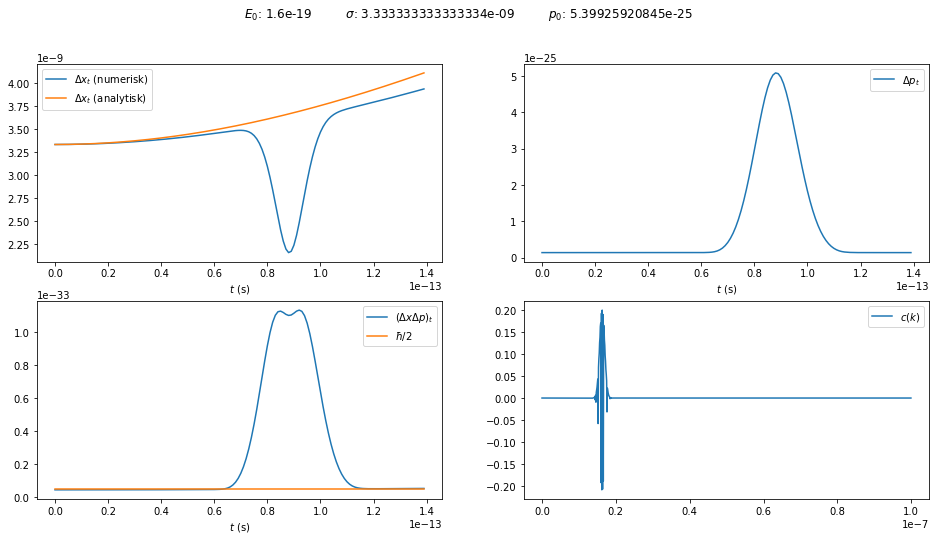

In [259]:
BigPsi = getBigPsi(E0=V0,sigma=N/3*dx,harmonic=False)  #p0=1E-12

tArr=arange(140)*1E-15

fig, axArr =plt.subplots(2, 2,figsize=(16,8))

plt.suptitle('$E_0$: '+str(E0)+'\t $\sigma$: '.expandtabs()+str(sigma)+'\t $p_0$: '.expandtabs()+str(p0))

axArr[0,0].plot(tArr,sigmaX(tArr).reshape(tArr.shape), label='$\Delta x_t$ (numerisk)')
axArr[0,0].plot(tArr,analyticSigmaX(tArr).reshape(tArr.shape), label='$\Delta x_t$ (analytisk)')
axArr[0,0].legend(loc='best')
axArr[0,0].set_xlabel('$t$ (s)')
axArr[0,1].plot(tArr,sigmaP(tArr).reshape(tArr.shape), label='$\Delta p_t$')
axArr[0,1].legend(loc='best')
axArr[0,1].set_xlabel('$t$ (s)')
axArr[1,0].plot(tArr,heisenProd(tArr).reshape(tArr.shape), label='$(\Delta x \Delta p)_t$')
axArr[1,0].plot(tArr,ones_like(tArr)*hbar/2, label="$\hbar/2$")
axArr[1,0].legend(loc='best')
axArr[1,0].set_xlabel('$t$ (s)')
axArr[1,1].plot(x,c, label='$c(k)$')
axArr[1,1].legend(loc='best')

plt.show()
animator();

Av grafene ser vi at den numeriske $\Delta x_t$ tilnærmet følger likning \eqref{eq:deltaX} for $E_0$ lik $1$ eV, frem til bølgepakken treffer potensialveggen ca. ved $t=75$ fs. Her presses bølgepakken sammen, slik at $\Delta x_t$  minker og $\Delta p_t$ øker. I praksis er all numerikk etter dette tidspunktet å regne som partikkel-i-boks-oppførsel, men vi ser at partikkelen er rimelig fri når den ikke har kontakt med potensialveggene, hvilket viser seg i at uskarphetsproduktet tilnærmet oppnår minimal verdi i dette området som følge av at $\Psi$ får beholde gaussformen.  
Av animasjonen ser vi tydelig dispersjonen under traversering. Bølgepakken beveger seg med gruppehastighet lik midlere partikkelhastighet $v_g=\frac{\partial \omega}{\partial k}\big|_{k_0}=\frac{p_0}{m}$. Da potensialveggene er uendelig harde er kollisjonen tilnærmet elastisk. Hastigheten bevares ganske godt i første kollisjon, men avtar litt etter andre. Dette kan tildels komme av numeriske feilforplantninger.


# Oppgave 2

Vi løser i denne omgang likning \eqref{eq:TUSL} for en partikkel i et harmonisk potensiale med fjærkonstant $k=V_0/2$ og angulær frekvens $\omega=\sqrt{k/m}$. Både bundne tilstander, hvor $E<V(\pm \infty)$ og ubundne tilstander, der $E>V(\pm \infty)$ løsninger viser seg å være løsninger av systemet. De bundne tilstandene $\{ \psi_i \}$ er Hermitepolynomer med et tilhørende diskret spekter 
\begin{equation}\label{eq:HarmE}
    E_i=(i+1/2)\hbar \omega \;\;\;\; i \in \mathbb{N}_0
\end{equation}
Energikvantiseringen er en generell egenskap ved bundne tilstander, og medfører at tilstandene har bestemt paritet som følge av at bølgetallet diskretiseres sammen med energien. Pariteten innebærer at tilstand $\psi_i$ vil ha $i$ nullpunkter innenfor potensialet. Dette ser vi f.eks. med av grunntilstanden $\psi_0 \propto e^{-m\omega (x-x_0)^2/2\hbar} $ som er en gaussisk bølgefunksjon med 0 nullpunkter og energi $E_0=\frac{1}{2}\hbar \omega$ . Generelt vil de bundne tilstandenen $\psi_i$ ha en sannsynlighetstetthet som til en viss grad likner den klassiske sannsynlighetstettheten for en partikkel som svinger med energien $E_i$ 
\begin{equation}\label{eq:classicalHarm}
    \rho=\frac{1}{\pi\sqrt{b_0^2-(x-x_0)^2}}
\end{equation}
Begge er maksimale nær de klassiske vendepunktene $b_0$ hvor $E_i=V(x)$. Likning \eqref{eq:classicalHarm} varierer i tiden gjennom utslaget, mens de bundne tilstandene $\psi_i$ er stasjonære egenfunksjoner av hamiltonoperatoren og har tidsuavhengig sannsynlighetsfordeling. Når vi gjør som tidligere og uttrykker bølgepakken \eqref{eq:Gaussian} ved hjelp av $\{ \psi_i \}$ får vi en forventet sannsynlighetstetthet som viser seg å oscillere harmonisk med $\langle x \rangle_t=x_0+b_0cos(\omega t)$ akkurat som en klassisk partikkel.

De ubundne tilstandene tilsvarer partikler som ikke lar seg fange av potensialet, da de har så stor energi at de bryter i stykker fjæren. Dette innebærer at de ubundne tilstandene tilsvarer planbølger med kontinuerlig energispekter.  

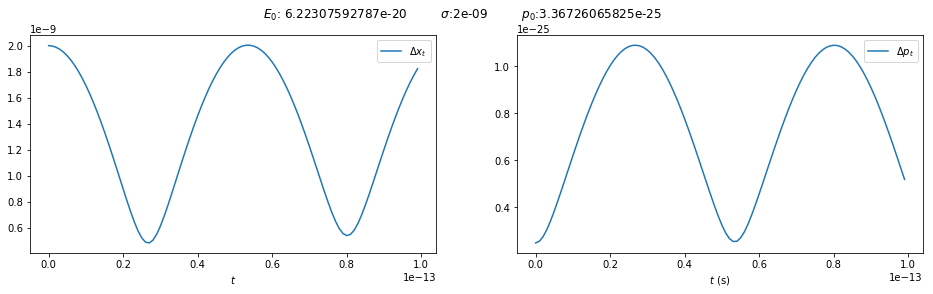

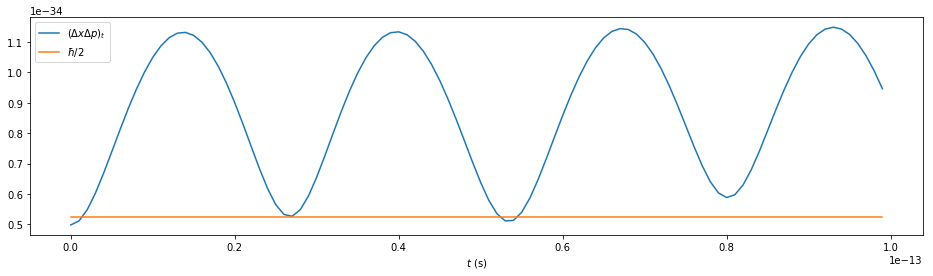

In [260]:
BigPsi = getBigPsi(E0=(2E9+0.5)*hbar*omega, sigma = N / 5* dx, harmonic=True) 

tArr=arange(100)*1E-15

fig, axArr =plt.subplots(1, 2, sharex=True,figsize=(16,4))

plt.suptitle('$E_0$: '+str(E0)+'\t $\sigma$:'.expandtabs()+str(sigma)+'\t $p_0$:'.expandtabs()+str(p0))

axArr[0].plot(tArr,sigmaX(tArr).reshape(tArr.shape),label='$\Delta x_t$')
axArr[0].legend(loc='best')
axArr[0].set_xlabel('$t$')
axArr[1].plot(tArr,sigmaP(tArr).reshape(tArr.shape), label='$\Delta p_t$')
axArr[1].legend(loc='best')
axArr[1].set_xlabel('$t$ (s)')

plt.figure(figsize=(16,4))
plt.plot(tArr,heisenProd(tArr).reshape(tArr.shape), label='$(\Delta x \Delta p)_t$')
plt.plot(tArr,ones_like(tArr)*hbar/2, label="$\hbar/2$")
plt.legend(loc='best')
plt.xlabel("$t$ (s)")
plt.show()

animator()

For $E_0$ som angitt i figuren varierer sannsynlighetsfordelingen harmonisk i potensialet. Forventningsverdiene varierer også harmonisk, faseforskyvd en halv bølgelengde, hvilket innebærer at uskarphetsproduktet også oppnår minimalverdien periodisk.   
Jo større utslag partikkelen har, jo større blir potensialgradienten, og dermed kraften på partikkelen. Sannsynlighetsfordelingen presses sammen i ytterkantene ettersom $\Delta x_t$ minker når det de økte kreftene begrenser partikkelens posisjon, og $\Delta p_t$ øker ettersom bølgepakken får et større impulsinnhold. Partikkelen er fri i sentrum av potensialet, slik at fordelingen her tilsvarer en gaussfordeling med minimalt uskarphetsprodukt. Her er $\Delta x_t$ størst ettersom partikkelen har størst hastighet i dette punktet slik at den følgelig kan befinne seg på et større område. Videre er $\Delta p_t$ minst her ettersom bølgepakken med dette svarer til færre impulsverdier i frekvensområdet.   

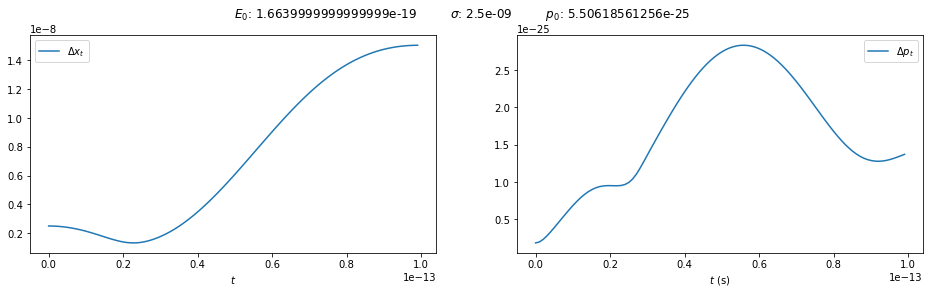

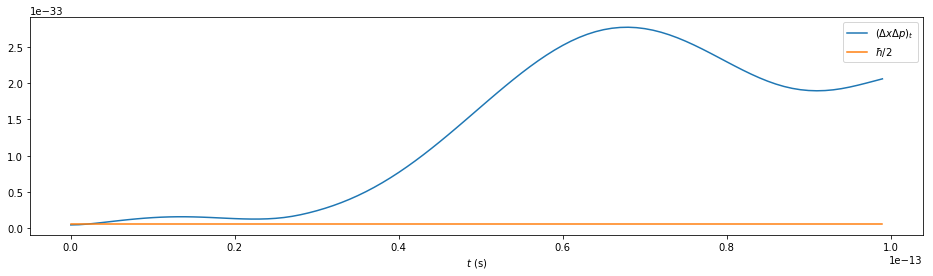

In [261]:
BigPsi = getBigPsi(E0=V0+0.04*V0, sigma = N/4* dx, harmonic=True)

tArr=arange(100)*1E-15

fig, axArr =plt.subplots(1, 2, sharex=True,figsize=(16,4))

plt.suptitle('$E_0$: '+str(E0)+'\t $\sigma$: '.expandtabs()+str(sigma)+'\t $p_0$: '.expandtabs()+str(p0))

axArr[0].plot(tArr,sigmaX(tArr).reshape(tArr.shape),label='$\Delta x_t$')
axArr[0].legend(loc='best')
axArr[0].set_xlabel('$t$')
axArr[1].plot(tArr,sigmaP(tArr).reshape(tArr.shape),label='$\Delta p_t$')
axArr[1].legend(loc='best')
axArr[1].set_xlabel('$t$ (s)')

plt.figure(figsize=(16,4))
plt.plot(tArr,heisenProd(tArr).reshape(tArr.shape), label='$(\Delta x \Delta p)_t$')
plt.plot(tArr,ones_like(tArr)*hbar/2, label="$\hbar/2$")
plt.legend(loc='best')
plt.xlabel("$t$ (s)")
plt.show()

animator(time=180)

Med $E_0$ litt større enn $V_0$ har partikkelen stor nok energi til å komme over potensialet, noe den tilsynelatende vil gjøre ca. halvparten av gangene, skal vi tro det faktum at sannsynlighetsfordelingen splittes i to når partikkelen treffer potensialet. Den andre halvparten av gangene vil den falle ned i potensialet og anta en harmonisk varierende tilstand som grenser til den klassiske sannsynlighetsfordelingen. Siden energien er såppas stor er sannsynligheten for tunnelering relativt betydelig i dette tilfellet. At $\Delta x_t$ og $\Delta p_t$ følger samme trend kan tyde på at det er andre faktorer som spiller inn i dette tilfellet, f.eks. i form av numeriske feilforplantninger.   